In [27]:
import os
import time

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp

import tensorflow as tf

In [28]:
# The layers and weights of each layer considered when 
# calculating the content loss during gradient descent.

content_layers  = [
    'block4_conv2'
]

content_weights = [
    1.0
]

In [29]:
# Load the VGG-19 network weights.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

out = [vgg.get_layer(name).output for name in content_layers]
vgg = tf.keras.Model([vgg.inputs], out)

vgg.trainable = False

In [30]:
def get_content_loss(content_targets, content_outputs):
  ''' Return the loss between content targets and content outputs.

  This function returns the loss between the content targets and the content
  outputs. As per the paper "Image Style Transfer Using Convolutional Neural
  Networks" (Gatys et al. 2014) this loss is the total euclidean between
  the feature map representations of the images.

  Parameters:
    content_targets (dict) - The target feature map representations.
    content_outputs (dict) - The output feature map representations

  Returns:
    The sum of the euclidean distances between each layer of feature maps in
    content_targets/content_outputs.
  '''

  loss = 0

  for name, weight in zip(content_layers, content_weights):
    loss += weight * tf.math.reduce_sum(
        tf.math.squared_difference(
          content_targets[name],
          content_outputs[name]
        )
    )

  return loss

In [31]:
epochs    = 2048
optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [32]:
def content_reconstruction(content, reconstruction, epochs=epochs, optimizer=optimizer):
  ''' Perform content reconstruction for the given image.

  This function performs content reconstruction for a given image. As per the
  paper "Image Style Transfer Using Convolutional Neural Networks"
  (Gatys et al. 2014) this is performed via gradient descent upon
  the reconstruction image using the difference in the high-level
  feature maps of the content and reconstruction images for loss.

  Parameters:
    content         (tf.Variable) - The content image.
    reconstruction  (tf.Variable) - The reconstruction image.
    
    epochs (int) - The number of epochs for gradient descent.

    optimizer (tf.keras.optimizers.Optimizer) - The gradient descent optimizer.
  '''

  content_targets = dict(zip(content_layers, vgg(content)))

  for epoch in range(epochs):    
    with tf.GradientTape() as tape:
      
      content_outputs = dict(zip(content_layers, vgg(reconstruction)))

      loss = get_content_loss(content_targets, content_outputs)
      grad = tape.gradient(loss, reconstruction)

    optimizer.apply_gradients([(grad, reconstruction)])
    reconstruction.assign(tf.clip_by_value(reconstruction, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 == 0:
      print('Epoch [{:4} / {:4}]: Loss = {:10.4f}'.format(epoch, epochs, loss))

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
root = os.path.join('drive', 'My Drive', 'CITS4404 Project')

content_path = 'Content'
content_file = 'Elephant.jpeg'

image_h = 512
image_w = 512

In [35]:
# Read, reshape and scale the content image.
content = plt.imread(os.path.join(root, content_path, content_file))
content = content.reshape([1, image_h, image_w, 3])
content = content / 255.0

# Initialize the reconstructed image to white-noise.
initial        = tf.random.uniform([1, image_h, image_w, 3], minval=0.0, maxval=1.0, dtype=tf.float32)
reconstruction = tf.Variable(initial, trainable=True, dtype=tf.float32)

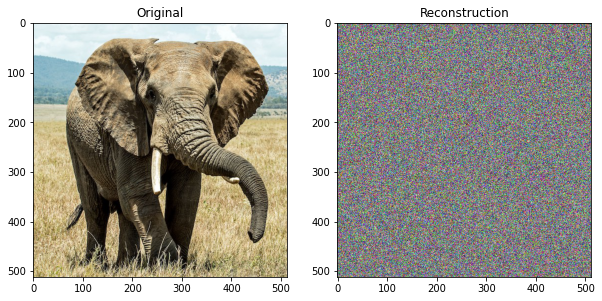

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(content[0])
ax[1].imshow(reconstruction[0].numpy())

ax[0].set_title('Original')
ax[1].set_title('Reconstruction')

plt.show()

In [37]:
time_1 = time.time()

content_reconstruction(content, reconstruction)

time_2 = time.time()
print('Total elapsed time: {} seconds'.format(time_2 - time_1))

Epoch [   0 / 2048]: Loss = 352034144.0000
Epoch [ 100 / 2048]: Loss = 23713048.0000
Epoch [ 200 / 2048]: Loss = 10042691.0000
Epoch [ 300 / 2048]: Loss = 4422684.0000
Epoch [ 400 / 2048]: Loss = 1951114.6250
Epoch [ 500 / 2048]: Loss = 899023.8125
Epoch [ 600 / 2048]: Loss = 475043.0938
Epoch [ 700 / 2048]: Loss = 289589.3125
Epoch [ 800 / 2048]: Loss = 199942.5781
Epoch [ 900 / 2048]: Loss = 151154.4062
Epoch [1000 / 2048]: Loss = 121600.9531
Epoch [1100 / 2048]: Loss = 102004.0625
Epoch [1200 / 2048]: Loss = 87962.4062
Epoch [1300 / 2048]: Loss = 77364.5781
Epoch [1400 / 2048]: Loss = 68975.2500
Epoch [1500 / 2048]: Loss = 62135.8047
Epoch [1600 / 2048]: Loss = 56377.5469
Epoch [1700 / 2048]: Loss = 51458.3086
Epoch [1800 / 2048]: Loss = 47226.2578
Epoch [1900 / 2048]: Loss = 43538.1680
Epoch [2000 / 2048]: Loss = 40286.3047
Total elapsed time: 241.4126009941101 seconds


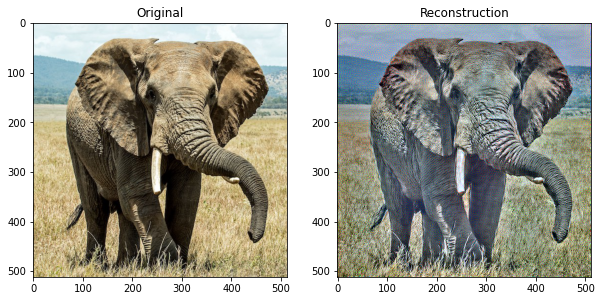

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(content[0])
ax[1].imshow(reconstruction[0].numpy())

ax[0].set_title('Original')
ax[1].set_title('Reconstruction')

plt.show()